## Home Credit Default Risk

*  각 고객의 정보를 기반으로 해당 고객이 대출한 돈을 갚을 수 있을지 없을지 (상환능력이 있는가) 에 대한 확률을 예측하는 대회
* 다양한 대체 데이터를 활용하여 고객의 상환 능력을 예측
* 최종 결과로는 Application_test 데이터 셋에 있는 각SK_ID_CURR의 “TARGET” 변수에 대한 확률을 예측하여 제출
* 각 대출지원자가 대출 상환에 어려움을 겪을 것인지, 아닌지를 예측하는 문제로, 전형적인 **분류문제**에 해당
* 평가지표 : roc, auc
* 기본 설명 : https://medium.com/mighty-data-science-bootcamp/kaggle-%EB%8F%84%EC%A0%84%EA%B8%B0-home-credit-default-risk-part-1-735030d40ee0

### **데이터 구조**
* 7개 데이터셋 
* application 데이터 (**메인데이터**) 설명 : https://chocoffee20.tistory.com/6 
* burea 데이터 설명 : https://chocoffee20.tistory.com/8?category=911962

* **aplication 데이터**
 - train/test set 
 - 홈 크레딧에 대출을 신청한 당시 작성한 내용을 알 수 있음. 모든 대출에는 자체 행이 있고 SK_ID_CURR로 식별된다. 
 - 훈련 데이터의 target data : 1(지불에 어려움을 겪는 고객=대출이 상환되지 않은 고객,24825개 데이터), 0(다른 모든 경우=대출이 상환된 고객, 282686개 데이터) --> 불균형(highly unbalance)한 데이터
 
* **bureau 데이터**
 - 개인신용평가기관(Credit Bureau)에 기록된 신청자의 과거 타금융기관과 신용거래 내역
 - bureau : 다른 금융 기관의 고객의 이전 신용 데이터. 각 이전 신용은 자체적인 행이 있지만 application data에서 하나의 대출은 여러개의 previous credit을 가질 수 있다. 
 - bureau_balance : 위 bureau의 월별 데이터로 각 행은 한달을 말하고 매월 한 행씩 여러행을 가진다. 

 
* **Previous 데이터**
 - 홈 크레딧에서 과거 대출기록으로 한 고객당 여러개의 이전 대출 이력을 가질 수 있다. 
 
 
* **나머지**
 - POS_CASH_BALANCE : 고객의 point of sale, 현금 대출에 대한 월별 데이터. 각 행은 한달을 뜻하고 하나의 대출은 여러 행을 가질 수 있다. 
 - credit_card_balance : 신용카드 데이터. 각 행은 신용카드 잔액 한달 데이터를 뜻한다. 
 - installments_payment : 이전 대출에서 payment 히스토리 
 
### **참고 사이트**
* 간단정리 : https://bkshin.tistory.com/entry/%EC%BA%90%EA%B8%80-5-Home-Credit-Default-Risk
 - Encoding : Label encoding, One-Hot encoding
 - feature engineering : Polynomial feature, Domain Knowledge feature , Aggregation 한(`mean`, `max`, `min`, `sum`) feature를 추가
 - 결측값 처리
 - 각 Feature와 Target 간의 상관계수를 살펴보아 가장 중요시되는 피쳐 도출 
 - 피쳐간 다중공선성 살펴보기 : 각 feature 간의 상관계수가 0.8이 넘어가면 둘 중 하나는 drop 
 - 예측모델 : Logistic Regression, Random Forest, LightGBM


* 자세한 코드1 :
https://velog.io/@fiifa92/Kaggle-Home-Credit-Default-Risk-%EB%8B%A4%EC%84%AF-%EB%B2%88%EC%A7%B8-%EB%AA%A8%EB%8D%B8-%ED%95%99%EC%8A%B5-%EB%B0%8F-%EC%84%B1%EB%8A%A5-%ED%8F%89%EA%B0%80

* 자세한코드2:
https://john-analyst.medium.com/%EC%BA%90%EA%B8%80-home-credit-default-risk-9225050b6fa6

* 자세한코드3 : 
https://lsjsj92.tistory.com/437?category=796397 

### EDA , basicFE(feature engineering) and LGB 첫번째 노트북 필사

#### 1. 모듈 임포트

In [2]:
# 기본 
import numpy as np
import pandas as pd
import seaborn as sns
import datetime

# 데이터 핸들링 
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# 자연어 처리
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams


# 모델 
import os
import xgboost as xgb
import lightgbm as lgb

# 시각화
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('max_columns', 150)

#### 2. 데이터 불러오기

In [3]:
folder = '../input/home-credit-default-risk'
# pd.read_csv(os.path.join(folder,'.csv'))
application_train = pd.read_csv(os.path.join(folder,'application_train.csv'))
application_test = pd.read_csv(os.path.join(folder,'application_test.csv'))
bureau = pd.read_csv(os.path.join(folder,'bureau.csv'))
bureau_balance = pd.read_csv(os.path.join(folder,'bureau_balance.csv'))
POS_CASH_balance = pd.read_csv(os.path.join(folder,'POS_CASH_balance.csv'))
credit_card_balance = pd.read_csv(os.path.join(folder, 'credit_card_balance.csv'))
previous_application = pd.read_csv(os.path.join(folder, 'previous_application.csv'))
installments_payments = pd.read_csv(os.path.join(folder, 'installments_payments.csv'))
sample_submission = pd.read_csv(os.path.join(folder, 'sample_submission.csv'))


#### 3. EDA 탐색적 데이터 분석

In [4]:
application_train.head()
# 122 columns ! 

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

#### 3-1. categorical features 살펴보기

In [5]:
## target data 
application_train.TARGET.value_counts(normalize=True)
### -> 불균형한 클래스임을 알 수 있지만, 여기선 중요한 부분은 아님 

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

**cf ) 회전대출** 

은행이 대출 규모와 기간을 정해 두면 대출을 받는 사람이 자금 필요에 따라 대출 기간 안에 단기어음을 발행하는 것으로, 회전신용(revolving credit)이라고도 한다.
회전대출(revolving facility)은 대출을 받는 사람이 대출금을 한꺼번에 찾지 않아도 되고, 대출을 받더라도 만기 전에 상환할 수 있으며, 필요하면 또 대출을 받을 수 있어 편리하다.

In [6]:
# target과 name_contract_type의 2X2 table 
## name_contract_type : 대출이 현금(cash loans)인지 리볼빙(revolving loans)인지 여부를 나타내는 칼럼
### 리볼빙 : 약정된 결제일에 최소금액만 결제하고 나머지 대금은 대출로 이전하는 방식
pd.crosstab(application_train.TARGET , application_train.NAME_CONTRACT_TYPE , dropna=False , normalize='all')
### 대부분 현금대출을 했고, 현금대출을 한 사람 중 82.9%가 대출을 갚았다. 

NAME_CONTRACT_TYPE,Cash loans,Revolving loans
TARGET,,
0,0.829274,0.089997
1,0.075513,0.005216


In [7]:
# target과 CODE_GENDER의 table 
## CODE_GENDER : 고객의 성별 , XNA는 성별이 확인되지 않는 경우임
pd.crosstab(application_train.TARGET , application_train.CODE_GENDER, dropna=False)
### 여성들이 더 많은 대출을 받고 그들 중 더 많은 비율의 사람들이 대출을 갚는 것을 볼 수 있다.

CODE_GENDER,F,M,XNA
TARGET,,,
0,188278,94404,4
1,14170,10655,0


In [8]:
# FLAG_OWN_CAR 차소유여부(Y=1/N=0) 
# FLAG_OWN_REALTY 집, 아파트 보유여부(Y/N)
# OWN_CAR_AGE : 고객 자동차 연식 
## 코드 하나씩 돌려보면서 이해하기~! 
print('{0}명의 사람들이 부동산을 보유하고 있고 그 중{1}% 사람들이 대출을 상환하지못했다.'.format(application_train[application_train.FLAG_OWN_REALTY =='Y'].shape[0],
                                                          np.round(application_train[application_train.FLAG_OWN_REALTY=='Y'].TARGET.value_counts(normalize=True).values[1],3)*100))
print()
print('{0}명의 사람들이 차를 보유하고 있고 그 중{1}% 사람들이 대출을 상환하지못했다.'.format(application_train[application_train.FLAG_OWN_CAR  =='Y'].shape[0],
                                                          np.round(application_train[application_train.FLAG_OWN_CAR =='Y'].TARGET.value_counts(normalize=True).values[1],3)*100))
print()
print('차를 소유하고 있는 고객의 자동차 평균 연식(average age of the car) :{:.2f}년'.format(application_train.groupby(['FLAG_OWN_CAR'])['OWN_CAR_AGE'].mean().values[1]))

213312명의 사람들이 부동산을 보유하고 있고 그 중8.0% 사람들이 대출을 상환하지못했다.

104587명의 사람들이 차를 보유하고 있고 그 중7.199999999999999% 사람들이 대출을 상환하지못했다.

차를 소유하고 있는 고객의 자동차 평균 연식(average age of the car) :12.06년


In [9]:
# 자녀수와 가족현황의 table 
# CNT_CHILDREN : 자녀수 
# NAME_FAMILY_STATUS : 가족형태 ['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated' 'Unknown']
pd.crosstab(application_train.CNT_CHILDREN , application_train.NAME_FAMILY_STATUS, dropna=False)
## 결혼했지만 아이가 없는 경우가 많다. 따라서 우리는 가족의 형태로 크게 기혼자와 미혼자로 구분할 수 있다. 

NAME_FAMILY_STATUS,Civil marriage,Married,Separated,Single / not married,Unknown,Widow
CNT_CHILDREN,,,,,,
0,20947,126575,14132,38810,2,14905
1,6588,43696,4389,5578,0,868
2,1936,22496,1111,958,0,248
3,262,3190,122,85,0,58
4,33,370,12,9,0,5
5,5,74,2,1,0,2
6,2,17,1,0,0,1
7,1,5,0,0,0,1
8,0,2,0,0,0,0


In [10]:
# 자녀수와 가족 구성원 수 table
# CNT_FAM_MEMBERS : 고객 가족 구성원 수 
pd.crosstab(application_train.CNT_CHILDREN, application_train.CNT_FAM_MEMBERS, dropna=False)
## 1인 가족 형태, 아이가 없는 가정, 한부모가정, 보편적인 가정형태(부,모,아이) 등이 관찰된다.

CNT_FAM_MEMBERS,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,20.0
CNT_CHILDREN,,,,,,,,,,,,,,,,,
0,67847,147522,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,10835,50284,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,2317,24432,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,265,3452,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,26,403,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,5,79,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,2,19,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,1,6,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0


In [11]:
# NAME_TYPE_SUITE : 대출 신청시 동행인 ['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' 'NAN' 'Other_B' 'Group of people']
application_train['NAME_TYPE_SUITE'].value_counts(dropna=False)

Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
NaN                  1292
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64

In [12]:
# 대출신청동행인과 가족형태 table
pd.crosstab(application_train.NAME_TYPE_SUITE, application_train.NAME_FAMILY_STATUS, dropna=False)

## 두 변수의 관계에서 모순되는(contradict) 부분을 발견할 수 있다. 
## 예를 들어, 별거중(separated), 싱글(single) 또는 홀아비(widowed)의 가족형태에서
## 대출신청에 동행인이 있는 경우를 볼 수 있다. 이는 비공식적인 관계가 있을 수 있다는 의미이다.
# 또한 어린이(children)가 동행인으로 있는 경우가 있는데, 이는 어른 나이의 자녀라고 볼 수 있다. 


NAME_FAMILY_STATUS,Civil marriage,Married,Separated,Single / not married,Unknown,Widow
NAME_TYPE_SUITE,,,,,,
Children,253,1940,318,378,0,378
Family,3702,28617,1747,4150,0,1933
Group of people,29,165,20,44,0,13
Other_A,147,340,70,268,0,41
Other_B,171,854,132,486,0,127
"Spouse, partner",1247,9685,74,345,0,19
Unaccompanied,24112,154047,17334,39529,0,13504


In [13]:
# 소득유형과 수입 table
# NAME_INCOME_TYPE : 소득 유형 ['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed' 'Student' 'Businessman' 'Maternity leave']
# AMT_INCOME_TOTAL : 수입 
application_train.groupby(['NAME_INCOME_TYPE']).agg({'AMT_INCOME_TOTAL' : ['mean','median','count']})
## 소수의 사람들이 포함된 4개의 범주가 있다는 것을 알 수 있다
## 고소득 사업가, 출산휴가 중인 사람, 실업자, 학생
## 그리고 이 소수의 범주에 속하는 사람들이 꽤 높은 수입을 가지고 있다는 것은 꽤 흥미롭다. 
## 그리고 물론, 대부분의 사람들은 일을 한다.

AMT_INCOME_TOTAL                  
                                 mean    median   count
NAME_INCOME_TYPE                                       
Businessman             652500.000000  495000.0      10
Commercial associate    202955.327289  180000.0   71617
Maternity leave         140400.000000   90000.0       5
Pensioner               136401.292273  117000.0   55362
State servant           179737.969506  157500.0   21703
Student                 170500.000000  157500.0      18
Unemployed              110536.363636   78750.0      22
Working                 163169.889223  135000.0  158774

In [14]:
# NAME_INCOME_TYPE 소득유형 중 Maternity leave 출산휴가에서 성별 분포 확인
application_train[application_train['NAME_INCOME_TYPE']=='Maternity leave']['CODE_GENDER'].value_counts()

F    4
M    1
Name: CODE_GENDER, dtype: int64

In [15]:
# 소득유형과 직업유형 
# OCCUPATION_TYPE : 직업유형
s=pd.crosstab(application_train.NAME_INCOME_TYPE,application_train.OCCUPATION_TYPE,dropna=False).style.background_gradient(cmap='viridis',low=0.5,high=0).highlight_null('red')
s

OCCUPATION_TYPE,Accountants,Cleaning staff,Cooking staff,Core staff,Drivers,HR staff,High skill tech staff,IT staff,Laborers,Low-skill Laborers,Managers,Medicine staff,Private service staff,Realty agents,Sales staff,Secretaries,Security staff,Waiters/barmen staff
NAME_INCOME_TYPE,,,,,,,,,,,,,,,,,,
Businessman,0,0,0,1,0,0,0,0,0,0,7,0,0,0,0,0,0,0
Commercial associate,3970,892,1305,6528,4916,220,3495,204,12763,370,8916,1036,989,324,11104,343,1559,386
Maternity leave,1,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0
Pensioner,0,2,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0
State servant,729,261,453,6956,815,64,1033,55,1868,25,2142,2585,38,9,186,264,380,53
Student,1,0,0,3,1,0,0,0,5,2,0,0,0,0,0,0,0,1
Working,5112,3498,4188,14080,12871,279,6852,267,40548,1696,10306,4915,1625,418,20811,698,4782,908


In [16]:
# AMT_GOODS_PRICE : 대출받아서 사려고 한 상품의 총액수
print('Null 값인 데이터 수 : {0} 개'.format(application_train[application_train['AMT_GOODS_PRICE'].isnull()].shape[0]))
## 이는 278개의 대출만이 다른 종류의 대출을 가지고 있다는 것을 의미한다. 
## 다음 셀에서 더 깊이 생각해 보자!!

Null 값인 데이터 수 : 278 개


Text(0.5, 1.0, 'Credit amount to goods price')

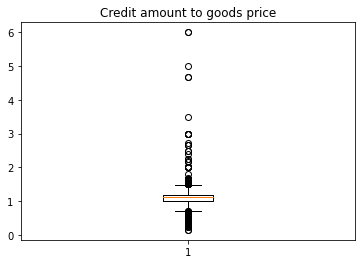

In [17]:
# 대출한 금액 중, 상품구매액이 차지하는 비율 확인하기 
# AMT_CREDIT : 대출총액 
non_zero_good_price = application_train[application_train['AMT_GOODS_PRICE'].isnull()==False]
credit_to_good_price = non_zero_good_price['AMT_CREDIT'] / non_zero_good_price['AMT_GOODS_PRICE']
plt.boxplot(credit_to_good_price)
plt.title('Credit amount to goods price')

##대부분 상품금액이 대출금액에서 차지하는 비율이 큼을 알 수 있다. (대출금 ~= 상품구매액)
##그러나 몇 가지 이상점이 관측된다. 

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Counts of housing type')

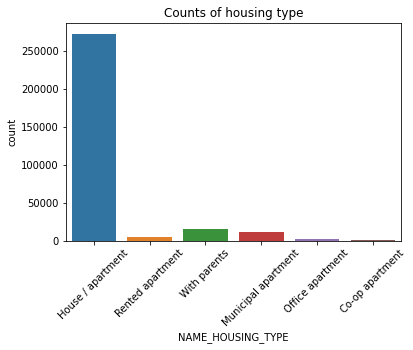

In [18]:
# NAME_HOUSING_TYPE : 주거 현황 ['House / apartment' 'Rented apartment' 'With parents' 'Municipal apartment' 'Office apartment' 'Co-op apartment']
sns.countplot(application_train['NAME_HOUSING_TYPE'])
plt.xticks(rotation=45)
plt.title('Counts of housing type')

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Count of ways to contact client')

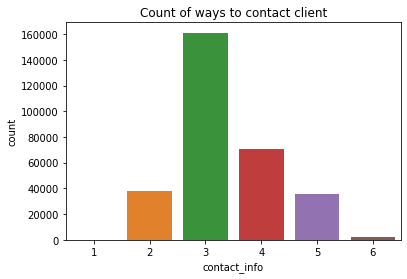

In [19]:
# 연락처 정보 제공 여부에 대한 정보를 담은 피쳐 (contact information)
# FLAG_MOBIL :  (1=YES, 0=NO)", 고객 휴대폰 번호 제공 여부
# FLAG_EMP_PHONE : (1=YES, 0=NO)", 고객 직장 번호 제공 여부
# FLAG_WORK_PHONE :  (1=YES, 0=NO)", 고객 자택 번호 제공 여부
# FLAG_CONT_MOBILE : (1=YES, 0=NO)", 고객 휴대폰 연결 가능 여부
# FLAG_PHONE : (1=YES, 0=NO)", 고객 자택 번호 제공 여부
# FLAG_EMAIL : (1=YES, 0=NO)", 고객 이메일 제공 여부
application_train['contact_info']=application_train['FLAG_MOBIL'] + application_train['FLAG_EMP_PHONE']+application_train['FLAG_WORK_PHONE']+ application_train['FLAG_CONT_MOBILE'] + application_train['FLAG_PHONE'] + application_train['FLAG_EMAIL']
sns.countplot(application_train['contact_info'])
plt.title('Count of ways to contact client')
### 대부분의 고객은 3가지 방법으로 연락을 주고받음

#### 3-2. 고객의 주변인들의 대출상환 불이행 (deliquency) 살펴보기 


It is very important to see **how many times** clients was late with payments or defaulted his loans. I suppose info about his **social circle is also important** (ㅁㅁㅁ_00_social_circle : 고객의 주변 사람들의 채무 불이행에 대한 정보를 담고 있는 피쳐). I'll divide values into 2 groups: 0, 1 and more than 1.

* OBS_30_CNT_SOCIAL_CIRCLE : 고객 주위 사람 중 30일 이상 지불이 늦을 수 있는 사람의 수
* DEF_30_CNT_SOCIAL_CIRCLE : 고객 주위 사람 중 30일 이상 지불이 **정말** 늦은 사람의 수

In [20]:
application_train.loc[application_train['OBS_30_CNT_SOCIAL_CIRCLE']>1, 'OBS_30_CNT_SOCIAL_CIRCLE']='1+'
application_train.loc[application_train['DEF_30_CNT_SOCIAL_CIRCLE'] > 1, 'DEF_30_CNT_SOCIAL_CIRCLE'] = '1+'
application_train.loc[application_train['OBS_60_CNT_SOCIAL_CIRCLE'] > 1, 'OBS_60_CNT_SOCIAL_CIRCLE'] = '1+'
application_train.loc[application_train['DEF_60_CNT_SOCIAL_CIRCLE'] > 1, 'DEF_60_CNT_SOCIAL_CIRCLE'] = '1+'

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn

<AxesSubplot:xlabel='DEF_60_CNT_SOCIAL_CIRCLE', ylabel='count'>

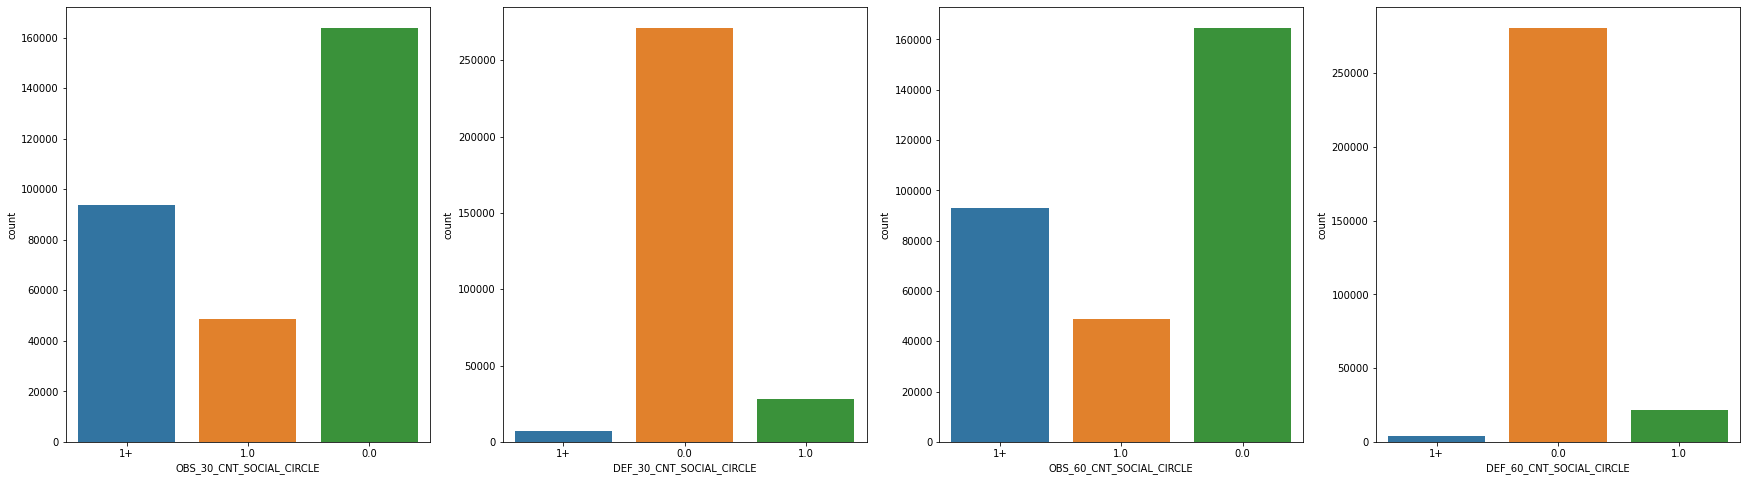

In [21]:
fig, ax = plt.subplots(figsize=(30,8))
plt.subplot(1,4,1)
sns.countplot(application_train['OBS_30_CNT_SOCIAL_CIRCLE'])
plt.subplot(1,4,2)
sns.countplot(application_train['DEF_30_CNT_SOCIAL_CIRCLE'])
plt.subplot(1, 4, 3)
sns.countplot(application_train['OBS_60_CNT_SOCIAL_CIRCLE'])
plt.subplot(1, 4, 4)
sns.countplot(application_train['DEF_60_CNT_SOCIAL_CIRCLE'])

#### 3-3. Continuous variables 살펴보기

##### AMT_INCOME_TOTAL : 수입

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, ' AMT_INCOME_TOTAL boxplot')

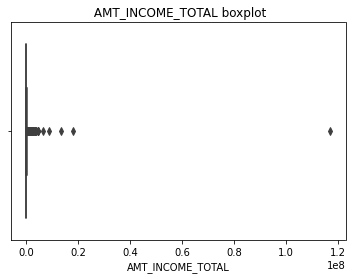

In [22]:
sns.boxplot(application_train['AMT_INCOME_TOTAL'])
plt.title(' AMT_INCOME_TOTAL boxplot')

In [23]:
np.percentile(application_train['AMT_INCOME_TOTAL'],90)
## 90% percentile에 해당하는 수입액

270000.0

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'AMT_INCOME_TOTAL boxplot on data within 90 percentile')

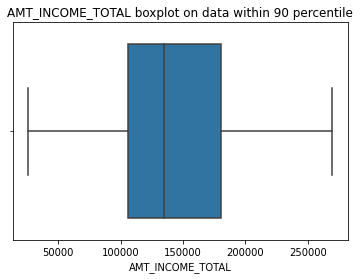

In [24]:
sns.boxplot(application_train[ application_train['AMT_INCOME_TOTAL'] < np.percentile(application_train['AMT_INCOME_TOTAL'],90) ]['AMT_INCOME_TOTAL'])
plt.title('AMT_INCOME_TOTAL boxplot on data within 90 percentile')
## 90% 범위내에 해당하는 수입 데이터 분포만 살펴보기 (이상치 제거하고 살펴보기)

In [25]:
application_train.groupby('TARGET').agg( {'AMT_INCOME_TOTAL' : ['mean','median','count']} )

AMT_INCOME_TOTAL                  
                   mean    median   count
TARGET                                   
0         169077.722266  148500.0  282686
1         165611.760906  135000.0   24825

Text(0.5, 1.0, 'AMT_INCOME_TOTAL histogram')

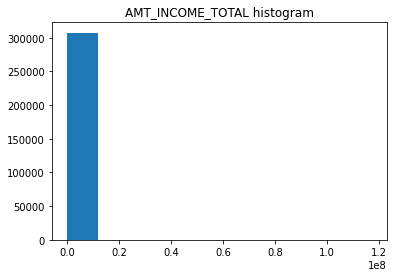

In [26]:
plt.hist(application_train['AMT_INCOME_TOTAL'])
plt.title('AMT_INCOME_TOTAL histogram')

Text(0.5, 1.0, 'AMT_INCOME_TOTAL histogram on data within 90 percentile')

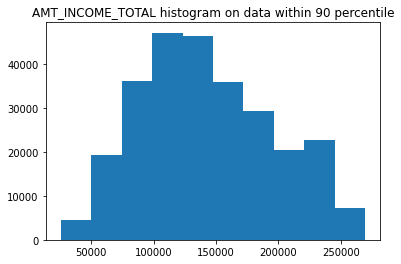

In [27]:
### 90% percentile에 해당하는 데이터에 한해서 히스토그램 그리기
plt.hist(application_train[application_train['AMT_INCOME_TOTAL'] < np.percentile(application_train['AMT_INCOME_TOTAL'], 90)]['AMT_INCOME_TOTAL'])
plt.title('AMT_INCOME_TOTAL histogram on data within 90 percentile')

Text(0.5, 1.0, 'AMT_INCOME_TOTAL histogram on data with log1p transformation')

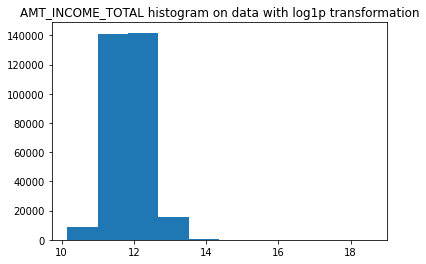

In [28]:
#### np.log1p() : 자연로그 log(1 + x) 변환
plt.hist(np.log1p(application_train['AMT_INCOME_TOTAL']))
plt.title('AMT_INCOME_TOTAL histogram on data with log1p transformation')

소득 분포를 통해 알 수 있는 점
* 1) 이상치 존재 : 소득 특징에는 몇개의 큰 이상치가 존재한다. 이는 부유한 개인 또는 데이터의 오류 때문일 수 있다.
* 2) 평균소득은 대출금 상환자와 상환하지 않은 사람이 거의 유사하다.
* 3) 데이터만 90퍼센트 이내에 두면 거의 정규 분포에 가깝다. 
* 4) 로그 변환도 정규분포 근사에 도움이 된다. 

##### AMT_CREDIT 대출 총액

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


Text(0.5, 1.0, 'AMT_CREDIT boxplot')

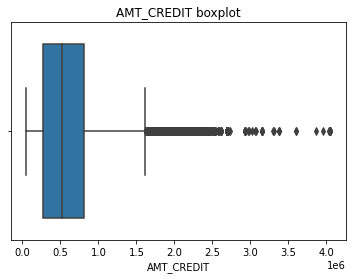

In [29]:
sns.boxplot(application_train['AMT_CREDIT'], orient='v')
plt.title('AMT_CREDIT boxplot')

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


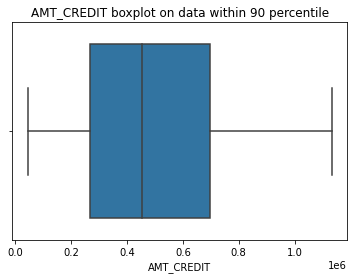

In [30]:
sns.boxplot(application_train[application_train['AMT_CREDIT'] < np.percentile(application_train['AMT_CREDIT'], 90)]['AMT_CREDIT'], orient='v');
plt.title('AMT_CREDIT boxplot on data within 90 percentile');

In [31]:
application_train.groupby('TARGET').agg( {'AMT_CREDIT' : ['mean','median','count']} )

AMT_CREDIT                  
                 mean    median   count
TARGET                                 
0       602648.282002  517788.0  282686
1       557778.527674  497520.0   24825

Text(0.5, 1.0, 'AMT_CREDIT histogram')

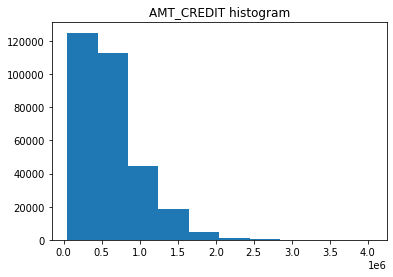

In [32]:
plt.hist(application_train['AMT_CREDIT'])
plt.title('AMT_CREDIT histogram')

Text(0.5, 1.0, 'AMT_INCOME_TOTAL histogram on data within 90 percentile')

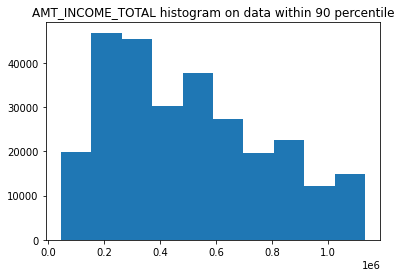

In [33]:
plt.hist(application_train[application_train['AMT_CREDIT'] < np.percentile(application_train['AMT_CREDIT'], 90)]['AMT_CREDIT'])
plt.title('AMT_INCOME_TOTAL histogram on data within 90 percentile')

Text(0.5, 1.0, 'AMT_CREDIT histogram on data with log1p transformation')

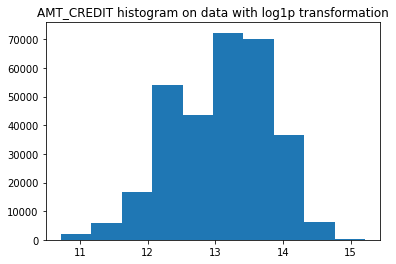

In [34]:
plt.hist(np.log1p(application_train['AMT_CREDIT']))
plt.title('AMT_CREDIT histogram on data with log1p transformation')

대출금액 분포를 통해 알 수 있는 점
* 1) 이상치 존재. mortgage(주택담보대출) 때문일 것으로 짐작
* 2) 평균 신용 금액은 대출금을 상환하는 사람과 상환하지 않는 사람의 경우가 거의 비슷한 값
* 3) 90% 데이터만 남기면 거의 정규분포에 근사 & 로그변환도 도움됨

##### DAYS_BIRTH 신청날 고객 나이

Text(0.5, 1.0, 'histogram of age in years')

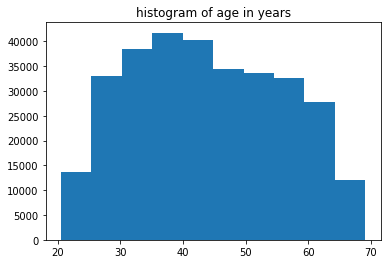

In [36]:
application_train['age'] = application_train['DAYS_BIRTH'] / -365
plt.hist(application_train['age'])
plt.title('histogram of age in years')

# 나이는 정규분포를 띄며 대부분 30세에서 40세 사이라는 것을 알 수 있다.

##### DAYS_EMPLOYED 신청일 기준 현재 직장에서 일한 일 수

Text(0.5, 1.0, 'Length of working at current workplace in years')

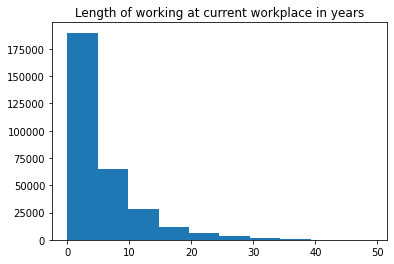

In [37]:
application_train.loc[application_train['DAYS_EMPLOYED']==365243 , 'DAYS_EMPLOYED']=0
application_train['years_employed'] = application_train['DAYS_EMPLOYED']/-365
plt.hist(application_train['years_employed'])
plt.title('Length of working at current workplace in years')

## -365243 라는 이상치가 존재하기때문에 0으로 대체하고 분포를 살펴본다.
## 대부분의 값이 0에 몰려있지만(많은 사람들이 일을 하지 않음) 자세히 살펴보자

In [38]:
application_train.groupby(['NAME_INCOME_TYPE']).agg( {'years_employed' : ['mean','median','count','max'], 'age':['median']})
## 비근로자들의 대다수는 연금수령자로 짐작되며, 근로자들은 한곳에서 꾸준히 일한 것으로 보인다.

years_employed                                     age
                               mean    median   count        max     median
NAME_INCOME_TYPE                                                           
Businessman                7.874795  6.280822      10  14.917808  47.498630
Commercial associate       5.833627  4.147945   71617  48.071233  39.780822
Maternity leave            7.224110  8.273973       5  10.306849  39.350685
Pensioner                  0.002448 -0.000000   55362  35.246575  60.413699
State servant              9.454441  7.205479   21703  48.172603  40.693151
Student                    6.835160  5.069863      18  21.931507  36.663014
Unemployed                 0.000000 -0.000000      22  -0.000000  45.860274
Working                    6.446909  4.427397  158774  49.073973  39.876712

In [40]:
## 좀 더 다양한 각도로 살펴보자
# 최종학력수준과 소득타입별 소득에 대한 집계(평균,중앙값,count,최대값)
# NAME_INCOME_TYPE : 소득타입 ['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed' 'Student' 'Businessman' 'Maternity leave']
# NAME_EDUCATION_TYPE : 최종 학력 수준 ['Secondary / secondary special' 'Higher education' 'Incomplete higher' 'Lower secondary' 'Academic degree']
application_train.groupby( ['NAME_EDUCATION_TYPE' , 'NAME_INCOME_TYPE']).agg( {'AMT_INCOME_TOTAL':['mean','median','count','max']} )

# 대출이 대부분 중등교육(secondary education)을 받은 근로자들에 의해 이루어진다는 것을 알 수 있다.

AMT_INCOME_TOTAL  \
                                                               mean   
NAME_EDUCATION_TYPE           NAME_INCOME_TYPE                        
Academic degree               Commercial associate    274688.372093   
                              Pensioner               203919.230769   
                              State servant           258847.826087   
                              Working                 226312.500000   
Higher education              Businessman             652500.000000   
                              Commercial associate    242283.998486   
                              Maternity leave         195000.000000   
                              Pensioner               171455.114974   
                              State servant           207116.161080   
                              Student                 231000.000000   
                              Unemployed              189000.000000   
                              Working                 194013.110125   
Incomplete higher             Commercial associate    206232.296029   
                              Pensioner               149437.155405   
                              State servant           173589.989610   
                              Student                 157500.000000   
                              Unemployed              126000.000000   
                              Working                 170659.490600   
Lower secondary               Commercial associate    168173.628261   
                              Pensioner               106468.010464   
                              State servant           143250.000000   
                              Working                 140070.652174   
Secondary / secondary special Commercial associate    181368.704601   
                              Maternity leave          58500.000000   
                              Pensioner               130863.482560   
                              State servant           159979.349061   
                              Student                 138681.818182   
                              Unemployed               70753.846154   
                              Working                 154261.801730   

                                                                       \
                                                       median   count   
NAME_EDUCATION_TYPE           NAME_INCOME_TYPE                          
Academic degree               Commercial associate  247500.00      43   
                              Pensioner             155700.00      26   
                              State servant         225000.00      23   
                              Working               202500.00      72   
Higher education              Businessman           495000.00      10   
                              Commercial associate  202500.00   24025   
                              Maternity leave       135000.00       3   
                              Pensioner             148500.00    8188   
                              State servant         180000.00    8863   
                              Student               175500.00       6   
                              Unemployed            180000.00       6   
                              Working               174134.25   33762   
Incomplete higher             Commercial associate  180000.00    3400   
                              Pensioner             135000.00     518   
                              State servant         157500.00     770   
                              Student               157500.00       1   
                              Unemployed             63000.00       3   
                              Working               157500.00    5585   
Lower secondary               Commercial associate  144000.00     460   
                              Pensioner              90000.00    1529   
                              State servant         119250.00     102   
                          

#### 4. Transforming and merging data 데이터 가공

train set 가공

In [44]:
# 자연로그 변환
application_train['AMT_INCOME_TOTAL'] = np.log1p(application_train['AMT_INCOME_TOTAL'])
application_train['AMT_CREDIT'] = np.log1p(application_train['AMT_CREDIT'])
# 결측치 처리
application_train['OWN_CAR_AGE'] = application_train['OWN_CAR_AGE'].fillna(0)

# 새로운 열 생성 : 대출총액/매달상환값
## AMT_CREDIT : 대출 총액
## AMT_ANNUITY : 매달 내야하는 돈 (이자포함)
application_train['app AMT_CREDIT / AMT_ANNUITY'] = application_train['AMT_CREDIT']/application_train['AMT_ANNUITY']

# 새로운 열 생성 : 외부데이터 점수의 평균
application_train['app EXT_SOURCE mean'] = application_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)

# 새로운 열 생성 : 외부데이터점수/신청날고객나이
## EXT_SOURCE : 외부 데이터 소스의 정규화된 점수
## DAYS_BIRTH : 신청날 고객 나이
application_train['app EXT_SOURCE_1 / DAYS_BIRTH'] = application_train['EXT_SOURCE_1'] / application_train['DAYS_BIRTH']

# 새로운 열 생성 : 총수입/12 - 매달상환값 = 한달수입-한달대출상환값
application_train['app AMT_INCOME_TOTAL / 12 - ANM_ANNUITY'] = application_train['AMT_INCOME_TOTAL']/12 - application_train['AMT_ANNUITY']

# 새로운 열 생성 : 총수입/매달상환값
application_train['app AMT_INCOME_TOTAL / AMT_ANNUITY'] = application_train['AMT_INCOME_TOTAL']/application_train['AMT_ANNUITY']

# 새로운 열 생성 : 총수입-대출받아서사려고한상품의총액
application_train['app AMT_INCOME_TOTAL - AMT_GOODS_PRICE'] = application_train['AMT_INCOME_TOTAL'] - application_train['AMT_GOODS_PRICE']

test set 가공 (train set과 동일한 방법으로 가공하기!)

In [45]:
# 위에서 진행했던 대출미납이 있는 주변인의 수 카테고리 1+ 추가 
application_test.loc[application_test['OBS_30_CNT_SOCIAL_CIRCLE'] > 1, 'OBS_30_CNT_SOCIAL_CIRCLE'] = '1+'
application_test.loc[application_test['DEF_30_CNT_SOCIAL_CIRCLE'] > 1, 'DEF_30_CNT_SOCIAL_CIRCLE'] = '1+'
application_test.loc[application_test['OBS_60_CNT_SOCIAL_CIRCLE'] > 1, 'OBS_60_CNT_SOCIAL_CIRCLE'] = '1+'
application_test.loc[application_test['DEF_60_CNT_SOCIAL_CIRCLE'] > 1, 'DEF_60_CNT_SOCIAL_CIRCLE'] = '1+'


# 새로운 열 생성 : 나이(year) = 대출신청시나이/-365
application_test['age'] = application_test['DAYS_BIRTH'] / -365
# 이상치 처리
application_test.loc[application_test['DAYS_EMPLOYED'] == 365243, 'DAYS_EMPLOYED'] = 0
# 새로운 열 생성 : 근무연수(year) = 근무일/-365
application_test['years_employed'] = application_test['DAYS_EMPLOYED'] / -365
# 자연로그 변환
application_test['AMT_INCOME_TOTAL'] = np.log1p(application_test['AMT_INCOME_TOTAL'])
application_test['AMT_CREDIT'] = np.log1p(application_test['AMT_CREDIT'])
# 이상치처리
application_test['OWN_CAR_AGE'] = application_test['OWN_CAR_AGE'].fillna(0)


# 새로운 열 생성
application_test['app AMT_CREDIT / AMT_ANNUITY'] = application_test['AMT_CREDIT'] / application_test['AMT_ANNUITY']
application_test['app EXT_SOURCE mean'] = application_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
application_test['app EXT_SOURCE_1 / DAYS_BIRTH'] = application_test['EXT_SOURCE_1'] / application_test['DAYS_BIRTH']
application_test['app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY'] = application_test['AMT_INCOME_TOTAL'] / 12. - application_test['AMT_ANNUITY']
application_test['app AMT_INCOME_TOTAL / AMT_ANNUITY'] = application_test['AMT_INCOME_TOTAL'] / application_test['AMT_ANNUITY']
application_test['app AMT_INCOME_TOTAL - AMT_GOODS_PRICE'] = application_test['AMT_INCOME_TOTAL'] - application_test['AMT_GOODS_PRICE']


In [46]:
## 이해가 잘 안됨...
for col in ['FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
           'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
            'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'WEEKDAY_APPR_PROCESS_START']:
    unique_values = list(set(list(application_train[col].astype(str).unique()) + list(application_test[col].astype(str).unique())))
    le.fit(unique_values)
    application_train[col] = le.transform(application_train[col].astype(str))
    application_test[col] = le.transform(application_test[col].astype(str))

In [47]:
train = application_train

In [48]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,contact_info,age,years_employed,app AMT_CREDIT / AMT_ANNUITY,app EXT_SOURCE mean,app EXT_SOURCE_1 / DAYS_BIRTH,app AMT_INCOME_TOTAL / 12 - ANM_ANNUITY,app AMT_INCOME_TOTAL / AMT_ANNUITY,app AMT_INCOME_TOTAL - AMT_GOODS_PRICE
0,100002,1,0,1,0,1,0,0.822338,0.828579,24700.5,351000.0,6,7,4,3,1,0.018801,-9461,-637,-3648.0,-2120,0.0,1,1,0,1,1,0,8,1.0,2,2,6,10,0,0,0,0,0,0,5,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,3,0,0.0149,5,0,1,1,1,1,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,4,25.920548,1.745205,0.000034,0.161787,-0.000009,-24700.431472,0.000033,-3.509992e+05
1,100003,0,0,0,0,0,0,0.824968,0.838032,35698.5,1129500.0,1,4,1,1,1,0.003541,-16765,-1188,-1186.0,-291,0.0,1,1,0,1,1,0,3,2.0,1,1,1,11,0,0,0,0,0,0,39,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,3,0,0.0714,0,0,2,0,2,0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4,45.931507,3.254795,0.000023,0.466757,-0.000019,-35698.431253,0.000023,-1.129499e+06
2,100004,0,1,1,1,1,0,0.811503,0.818492,6750.0,135000.0,6,7,4,3,1,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,8,1.0,2,2,1,9,0,0,0,0,0,0,11,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [49]:
test = application_test

In [50]:
# 결측치처리
train  = train.fillna(0)
test = test.fillna(0)

In [51]:
# 피쳐와 타겟분리
X = train.drop (['SK_ID_CURR', 'contact_info', 'TARGET'],axis=1)
y = train['TARGET']
X_test = test.drop(['SK_ID_CURR'],axis=1)

#### 5. 모델 훈련 LGB

https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/

https://lsjsj92.tistory.com/548

https://greatjoy.tistory.com/72

* Light GBM은 Gradient Boosting 프레워크로 Tree 기반 학습 알고리즘이다. 

In [53]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

params = {
    'boosting': 'dart',
    'application': 'binary',
    'learning_rate': 0.01,
    'num_leaves': 34,
    'max_depth': 5,
    'feature_fraction': 0.9,
    'scale_pos_weight': 2,
    'reg_alpha': 0.05,
    'reg_lambda': 0.1}

model=lgb.train(params, lgb.Dataset(X_train,y_train),1000,[lgb.Dataset(X_train,y_train),lgb.Dataset(X_valid, y_valid)], verbose_eval=10, early_stopping_rounds=20)


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.130939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13278
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 123
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:182: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[10]	valid_0's binary_logloss: 0.274239	valid_1's binary_logloss: 0.273401
[20]	valid_0's binary_logloss: 0.270119	valid_1's binary_logloss: 0.269341
[30]	valid_0's binary_logloss: 0.267774	valid_1's binary_logloss: 0.267056
[40]	valid_0's binary_logloss: 0.266665	valid_1's binary_logloss: 0.266032
[50]	valid_0's binary_logloss: 0.275513	valid_1's binary_logloss: 0.275015
[60]	valid_0's binary_logloss: 0.292973	valid_1's binary_logloss: 0.292611
[70]	valid_0's binary_logloss: 0.314404	valid_1's binary_logloss: 0.314138
[80]	valid_0's binary_logloss: 0.311141	valid_1's binary_logloss: 0.31087
[90]	valid_0's binary_logloss: 0.309334	valid_1's binary_logloss: 0.309044
[100]	valid_0's binary_logloss: 0.332143	valid_1's binary_logloss: 0.331953
[110]	valid_0's binary_logloss: 0.357417	valid_1's binary_logloss: 0.357296
[120]	valid_0's binary_logloss: 0.350529	valid_1's binary_logloss: 0.350404
[130]	valid_0's binary_logloss: 0.346056	valid_1's binary_logloss: 0.345933
[140]	valid_0's binary

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

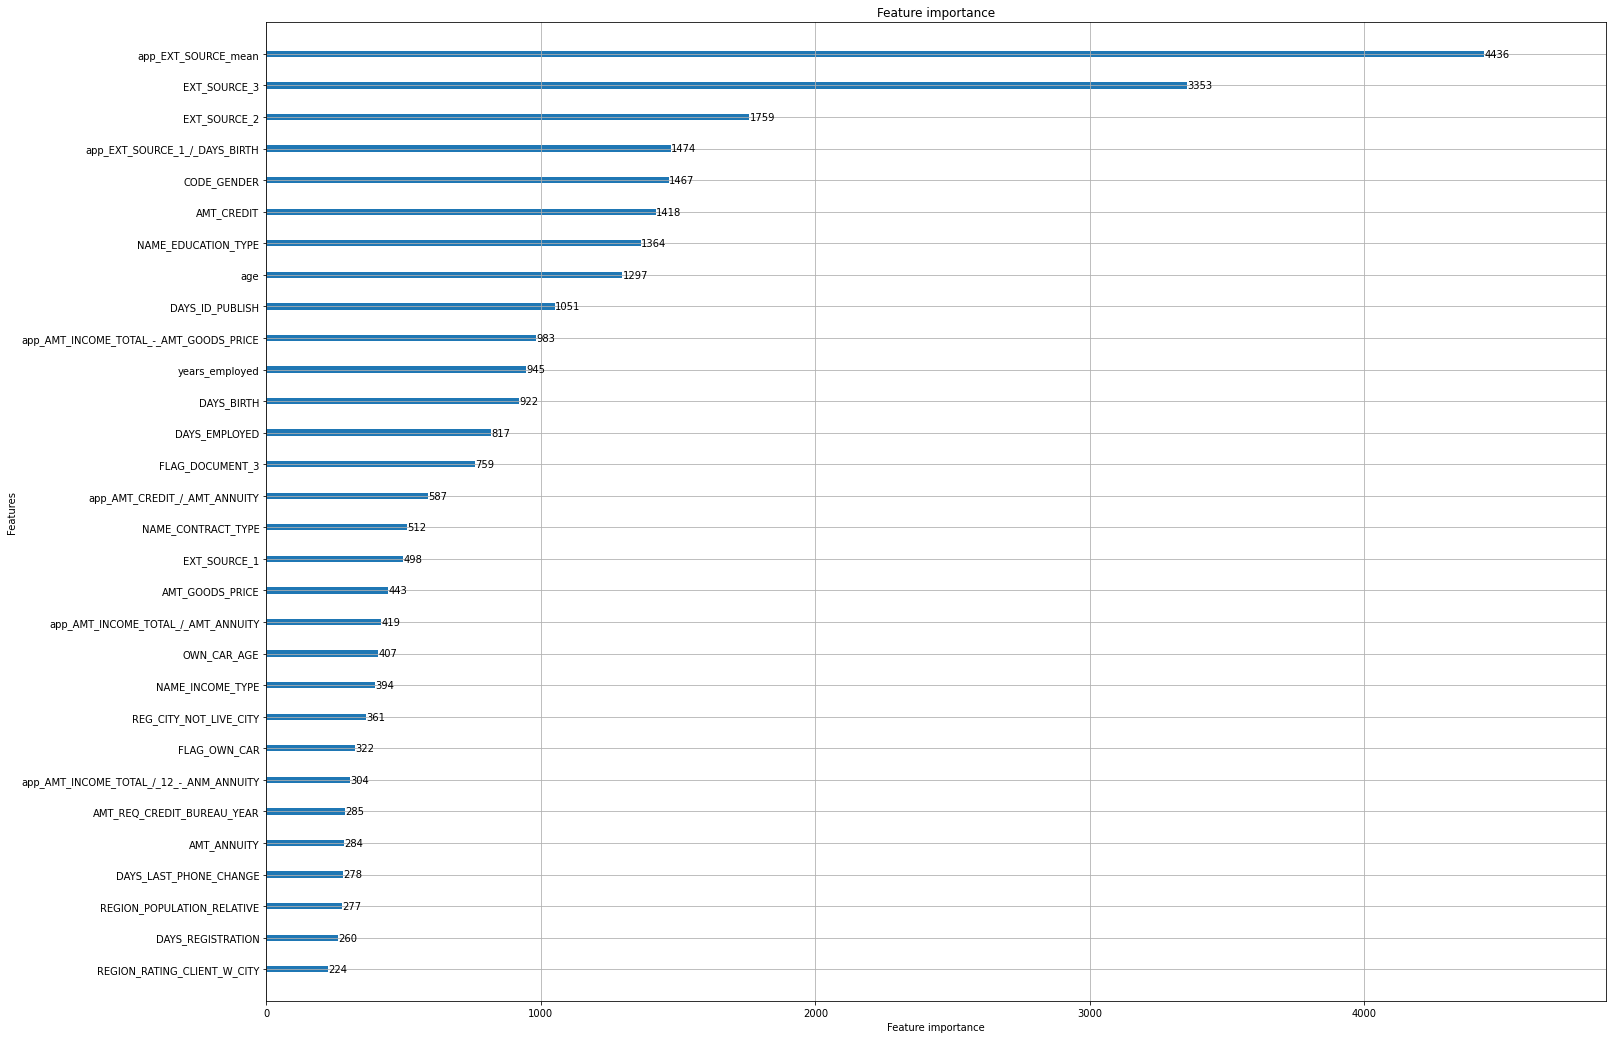

In [54]:
# 변수중요도 살펴보기
lgb.plot_importance(model,max_num_features=30,figsize=(24,18))

In [56]:
 # 교차검증
fold = StratifiedKFold(n_splits=10, shuffle = True, random_state=42)
params = {'colsample_bytree': 0.8,
 'learning_rate': 0.01,
 'num_leaves': 34,
 'subsample': 0.97,
 'max_depth': 8,
 'reg_alpha': 0.03,
 'reg_lambda': 0.07,
 'min_split_gain': 0.01,
 #'min_child_weight': 38
       }
prediction=np.zeros(X_test.shape[0]) #예측값 담을 그릇
for n_fold , (train_idx,valid_idx) in enumerate(fold.split(X,y)):
    train_x, train_y = X.iloc[train_idx] , y.iloc[train_idx]
    valid_x, valid_y = X.iloc[valid_idx], y.iloc[valid_idx]
    clf = lgb.LGBMClassifier(**params)
    clf.fit(train_x, train_y, 
                eval_set = [(train_x, train_y), (valid_x, valid_y)], eval_metric = 'auc', 
                verbose = 100, early_stopping_rounds = 50)
    prediction += clf.predict(X_test)

Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.746409	training's binary_logloss: 0.255388	valid_1's auc: 0.734615	valid_1's binary_logloss: 0.256929
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.746409	training's binary_logloss: 0.255388	valid_1's auc: 0.734615	valid_1's binary_logloss: 0.256929
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.745702	training's binary_logloss: 0.25541	valid_1's auc: 0.740053	valid_1's binary_logloss: 0.257015
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.745702	training's binary_logloss: 0.25541	valid_1's auc: 0.740053	valid_1's binary_logloss: 0.257015
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.745026	training's binary_logloss: 0.25562	valid_1's auc: 0.744159	valid_1's binary_logloss: 0.255748
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.745026	training's bina

stratifiedkFold : https://continuous-development.tistory.com/166

* stratifiedkFold는 target에 속성값의 개수를 동일하게 가져가게 하여 kfold같이 데이터가 한 곳으로 몰리는 것을 방지한다.

This was EDA and basic feature engineering. I know that feature engineering and modelling could be much better, but decided to make EDA the main focus of this kernel. I'll do better feature engineering and modelling in the next one.